In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew, kurtosis, mode, zscore, norm
from scipy.special import boxcox1p

# Pipeline and machine learning algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [33]:
# It is your job to predict the sales price for each house. 
# For each Id in the test set, you must predict the value of the SalePrice variable. 

# Load Data and Explore

Join Train and Test set so changes are made on both

In [34]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
test2=pd.read_csv("test.csv")
len_train=train.shape[0]
houses=pd.concat([train,test], sort=False)
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


# Exploratory data analysis (EDA)

In [35]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [37]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

In [38]:
houses.select_dtypes(include='object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [39]:
houses.select_dtypes(include=['float','int']).head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


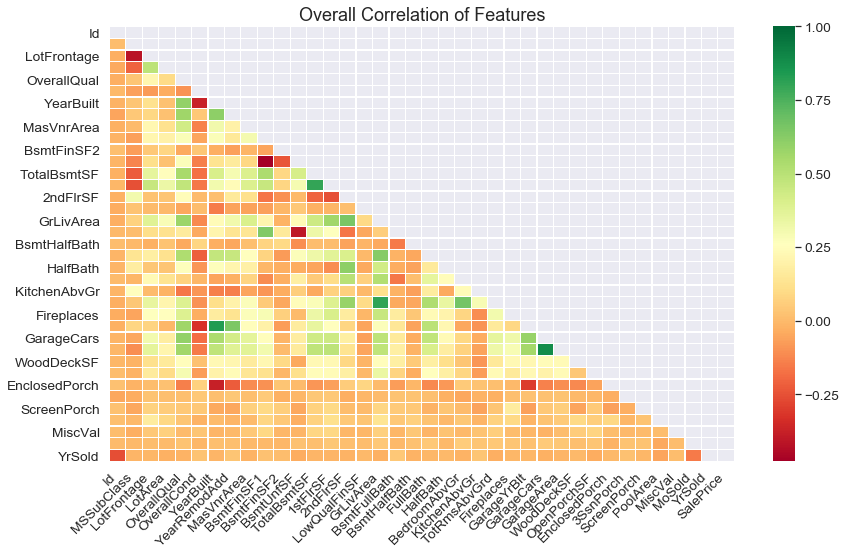

In [40]:
# Initiate correlation matrix
corrmat = houses.corr()

# Set-up mask
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set-up figure
plt.figure(figsize=(14, 8))
plt.title('Overall Correlation of Features', fontsize=18)
ax = sns.heatmap(corrmat, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})

# Fix bug in heatmap to display full high rows on top and bottom
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

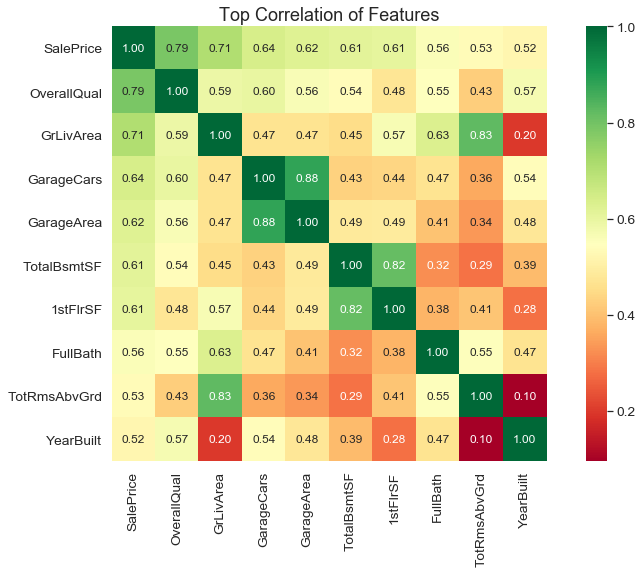

In [41]:
#saleprice correlation matrix
#set top number of variables for heatmap
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

plt.figure(figsize=(14, 8))
plt.title('Top Correlation of Features', fontsize=18)
sns.set(font_scale=1.25)
ax = sns.heatmap(cm, cbar=True, annot=True, cmap='RdYlGn', square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [42]:
houses.select_dtypes(include='object').isnull().sum()[houses.select_dtypes(include='object').isnull().sum()>0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

# Feature engineering

In [43]:
houses["PoolQC"] = houses["PoolQC"].fillna("None")
houses["MiscFeature"] = houses["MiscFeature"].fillna("None")
houses["Alley"] = houses["Alley"].fillna("None")
houses["Fence"] = houses["Fence"].fillna("None")
houses["FireplaceQu"] = houses["FireplaceQu"].fillna("None")

In [44]:
houses["LotFrontage"] = houses.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [45]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    houses[col] = houses[col].fillna('None')

In [46]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    houses[col] = houses[col].fillna(0)

In [47]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    houses[col] = houses[col].fillna(0)

In [48]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    houses[col] = houses[col].fillna('None')

In [49]:
houses["MasVnrType"] = houses["MasVnrType"].fillna("None")
houses["MasVnrArea"] = houses["MasVnrArea"].fillna(0)

In [50]:
houses['MSZoning'] = houses['MSZoning'].fillna(houses['MSZoning'].mode()[0])
houses["Functional"] = houses["Functional"].fillna("Typ")
houses['MSSubClass'] = houses['MSSubClass'].fillna("None")

In [51]:
houses = houses.drop(['Utilities'], axis=1)

In [52]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    houses[col] = houses[col].fillna(houses[col].mode()[0])

In [53]:
#Check remaining missing values if any 
houses_na = (houses.isnull().sum() / len(houses)) * 100
houses_na = houses_na.drop(houses_na[houses_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :houses_na})
missing_data.head()

,Missing Ratio
SalePrice,49.982871


In [54]:
# Converting some numerical variables that are really categorical type.

houses['MSSubClass'] = houses['MSSubClass'].apply(str)
houses['OverallCond'] = houses['OverallCond'].astype(str)
houses['YrSold'] = houses['YrSold'].astype(str)
houses['MoSold'] = houses['MoSold'].astype(str)

# Label Encoding

In [55]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(houses[c].values)) 
    houses[c] = lbl.transform(list(houses[c].values))

# shape        
print('Shape all_data: {}'.format(houses.shape))

Shape all_data: (2919, 80)


In [56]:
houses['TotalSF'] = houses['TotalBsmtSF'] + houses['1stFlrSF'] + houses['2ndFlrSF']

# Fix Skewness in Data

In [62]:
skewness = pd.DataFrame(houses.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])
skewness.head(20)

,Skew
MiscVal,21.958480
PoolArea,16.907017
LotArea,12.829025
LowQualFinSF,12.094977
3SsnPorch,11.381914
LandSlope,4.977715
KitchenAbvGr,4.304467
BsmtFinSF2,4.148275
EnclosedPorch,4.005950
ScreenPorch,3.948723


In [63]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if feat != 'SalePrice':
        houses[feat] = boxcox1p(houses[feat], lam)

There are 61 skewed numerical features to Box Cox transform


In [64]:
houses=pd.get_dummies(houses)
houses

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.730463,2.885846,5.831328,19.212182,0.730463,0.730463,1.540963,0.000000,2.440268,1.820334,...,0,0,0,1,0,0,0,0,1,0
1,1.194318,2.055642,6.221214,19.712205,0.730463,0.730463,1.540963,0.000000,2.259674,2.440268,...,0,0,0,1,0,0,0,0,1,0
2,1.540963,2.885846,5.914940,20.347241,0.730463,0.730463,0.000000,0.000000,2.440268,1.820334,...,0,0,0,1,0,0,0,0,1,0
3,1.820334,3.011340,5.684507,19.691553,0.730463,0.730463,0.000000,0.000000,2.440268,1.820334,...,0,0,0,1,1,0,0,0,0,0
4,2.055642,2.885846,6.314735,21.325160,0.730463,0.730463,0.000000,0.000000,2.602594,1.820334,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,15.394418,1.194318,3.932510,14.081426,0.730463,0.730463,1.540963,0.000000,1.820334,2.259674,...,0,0,0,1,0,0,0,0,1,0
1455,15.395553,1.194318,3.932510,14.013314,0.730463,0.730463,1.540963,0.000000,1.820334,1.820334,...,0,0,0,1,1,0,0,0,0,0
1456,15.396687,2.055642,7.620056,22.782058,0.730463,0.730463,1.540963,0.000000,2.055642,2.259674,...,0,0,0,1,1,0,0,0,0,0
1457,15.397821,3.340760,5.744420,20.046557,0.730463,0.730463,1.540963,0.000000,2.055642,1.820334,...,0,0,0,1,0,0,0,0,1,0


In [65]:
train=houses[:len_train]
test=houses[len_train:]

In [66]:
train['SalePrice']=np.log(train['SalePrice'])

In [67]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [68]:
X_train =train.drop('SalePrice', axis=1)
y_train =train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

# Build and Train Models

In [69]:
sc = StandardScaler()
X_train =sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [112]:
# Initialize our model
g_boost = GradientBoostingRegressor( n_estimators=6000, learning_rate=0.01,
                                     max_depth=5, max_features='sqrt',
                                     min_samples_leaf=15, min_samples_split=10,
                                     loss='ls', random_state =42
                                   )

# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
g_boost_pred = cross_val_score(g_boost, X_train, y_train, cv=kf, n_jobs=-1)
g_boost_pred.mean()

0.9072909017082494

In [113]:
# Initialize our model
ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
ridge_pred = cross_val_score(ridge, X_train, y_train, cv=kf, n_jobs=-1)
ridge_pred.mean()

0.8908029234026374

In [114]:
# Initialize our model
lasso = Lasso(alpha =0.001, random_state=1)

# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
lasso_pred = cross_val_score(lasso, X_train, y_train, cv=kf, n_jobs=-1)
lasso_pred.mean()

0.8925193584430176

In [115]:
elnet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
kf = KFold(n_splits=5)
elnet_pred = cross_val_score(elnet, X_train, y_train, cv=kf, n_jobs=-1)
elnet_pred.mean()

0.888256398964866

# Apply Grid Search for Best Parameters

In [74]:
# Gridsearch g_boost
param_grid={'n_estimators':[100], 
            'learning_rate': [0.1],
            'max_depth':[6],#4,6],
            'min_samples_leaf':[3],
            'max_features':[1.0],}

In [106]:
# Example of GridSearchCV
grid1 = GridSearchCV(g_boost, param_grid, cv = 10, verbose = 1, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid1.fit(X_train, y_train)
best_params1 = grid1.best_params_ 
best_score1 = np.round(np.sqrt(-1 * grid1.best_score_), 5)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.1s finished


0.13305

In [76]:
print(best_params1)

{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 100}


In [77]:
# Example of RandomizedSearchCV
grid2 = RandomizedSearchCV(g_boost, param_grid, cv = 10, verbose = 1, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid2.fit(X_train, y_train)
best_params2 = grid2.best_params_ 
best_score2 = np.round(np.sqrt(-1 * grid2.best_score_), 5)
best_score2

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.9s finished


# Run model with final parameters

In [101]:
pred = grid1.best_estimator_.predict(X_test)

In [102]:
preds=np.exp(pred)

In [104]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('DSKsubmission.csv', index=False)

In [105]:
output

,Id,SalePrice
0,1461,119970.044887
1,1462,160410.909694
2,1463,180289.564792
3,1464,196643.658063
4,1465,192857.111460
...,...,...
1454,2915,75839.962697
1455,2916,86210.177542
1456,2917,171257.034384
1457,2918,121543.107019
